In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
import statsmodels.api as sm
import warnings

In [148]:
from causallib.estimation import IPW
from causallib.datasets import load_nhefs
from causallib.evaluation import plots
from sklearn.linear_model import LogisticRegression
data = load_nhefs()
ipw = IPW(LogisticRegression(solver="liblinear"))
ipw.fit(data.X,data.a)
propensity = ipw.compute_propensity(data.X,data.a)

We want to remove seaborn dependency. There's only one function using seaborn but it's distplot which includes hist and kde. Here's the previous `plot_propensity_score_distribution` function:

In [142]:
def plot_propensity_score_distribution_with_sns(propensity, treatment, reflect=True, kde=False,
                                       cumulative=False, norm_hist=True, ax=None):
    """
    Plot the distribution of propensity score

    Args:
        propensity (pd.Series):
        treatment (pd.Series):
        reflect (bool): Whether to plot second treatment group on the opposite sides of the x-axis.
                        This can only work if there are exactly two groups.
        kde (bool): Whether to plot kernel density estimation
        cumulative (bool): Whether to plot cumulative distribution.
        norm_hist (bool): If False - use raw counts on the y-axis.
                          If kde=True, then norm_hist should be True as well.
        ax (plt.Axes | None):

    Returns:

    """
    # assert propensity.index.symmetric_difference(a.index).size == 0
    ax = ax or plt.gca()

    # bins = _calculate_mutual_bins(propensity, treatment)
    bins = np.histogram(propensity, bins="auto")[1]
    plot_params = dict(bins=bins, kde=kde, axlabel=False, norm_hist=norm_hist, ax=ax,
                       hist_kws=dict(cumulative=cumulative), kde_kws=dict(cumulative=cumulative))
    unique_treatments = np.sort(np.unique(treatment))
    for treatment_value in unique_treatments:
        cur_propensity = propensity.loc[treatment == treatment_value]
        sns.distplot(cur_propensity, label='treatment={}'.format(treatment_value), **plot_params)

    if reflect:
        if len(unique_treatments) != 2:
            raise ValueError("Reflecting density across X axis can only be done for two groups. "
                             "This one has {}".format(len(unique_treatments)))
        # Update line:
        if kde:
            last_line = ax.get_lines()[-1]
            last_line.set_ydata(-1 * last_line.get_ydata())
        # Update histogram bars:
        idx_of_first_hist_rect = \
            [patch.get_label() for patch in ax.patches].index('treatment={}'.format(unique_treatments[-1]))
        for patch in ax.patches[idx_of_first_hist_rect:]:
            patch.set_height(-1 * patch.get_height())

        # Re-set the view of axes:
        ax.relim()
        ax.autoscale()
        # Remove negation sign from lower y-axis:
        ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(x) if x >= 0 else str(-x)))

    ax.legend(loc="best")
    x_type = "Propensity" if propensity.between(0, 1, inclusive=True).all() else "Weights"
    ax.set_xlabel(x_type)
    y_type = "Probability density" if norm_hist else "Counts"
    ax.set_ylabel(y_type)
    ax.set_title("{} Distribution".format(x_type))
    return ax


Here's the new function, implementing the underlying `matplotlib` and `scipy` methods to reproduce exactly the same output. The only part that is hacky is the `alpha=0.5` which approximates the look of seaborn.

In [150]:
def plot_propensity_score_distribution(propensity, treatment, reflect=True, kde=False,
                                       cumulative=False, norm_hist=True, ax=None):
    """
    Plot the distribution of propensity score

    Args:
        propensity (pd.Series):
        treatment (pd.Series):
        reflect (bool): Whether to plot second treatment group on the opposite sides of the x-axis.
                        This can only work if there are exactly two groups.
        kde (bool): Whether to plot kernel density estimation
        cumulative (bool): Whether to plot cumulative distribution.
        norm_hist (bool): If False - use raw counts on the y-axis.
                          If kde=True, then norm_hist should be True as well.
        ax (plt.Axes | None):

    Returns:

    """
    # assert propensity.index.symmetric_difference(a.index).size == 0
    ax = ax or plt.gca()
    if kde and not norm_hist:
        warnings.warn("kde=True and norm_hist=False is not supported. Forcing norm_hist from False to True.")
        norm_hist=True
    bins = np.histogram(propensity, bins="auto")[1]
    plot_params = dict(bins=bins,  density=norm_hist, alpha=0.5, cumulative=cumulative)

    unique_treatments = np.sort(np.unique(treatment))
    for treatment_value in unique_treatments:
        cur_propensity = propensity.loc[treatment == treatment_value]
        cur_color = f"C{treatment_value}"
        ax.hist(cur_propensity, label = f"treatment = {treatment_value}", color=cur_color,**plot_params)
        if kde:
            from scipy.stats import gaussian_kde
            cur_kde = gaussian_kde(cur_propensity)
            min_support = max(0,cur_propensity.values.min() - cur_kde.factor)
            max_support = min(1, cur_propensity.values.max() +  cur_kde.factor)
            X_plot = np.linspace(min_support,max_support,200)
            if cumulative:
                density = np.array([cur_kde.integrate_box_1d(X_plot[0], x_i) for x_i in X_plot])
                ax.plot(X_plot,density,color=cur_color,)
            else:    
                ax.plot(X_plot,cur_kde.pdf(X_plot),color=cur_color,)
    if reflect:
        if len(unique_treatments) != 2:
            raise ValueError("Reflecting density across X axis can only be done for two groups. "
                             "This one has {}".format(len(unique_treatments)))
        # Update line:
        if kde:
            last_line = ax.get_lines()[-1]
            last_line.set_ydata(-1 * last_line.get_ydata())
        # Update histogram bars:
        idx_of_first_hist_rect = \
            [patch.get_label() for patch in ax.patches].index('treatment = {}'.format(unique_treatments[-1]))
        for patch in ax.patches[idx_of_first_hist_rect:]:
            patch.set_height(-1 * patch.get_height())

        # Re-set the view of axes:
        ax.relim()
        ax.autoscale()
        # Remove negation sign from lower y-axis:
        ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(x) if x >= 0 else str(-x)))

    ax.legend(loc="best")
    x_type = "Propensity" if propensity.between(0, 1, inclusive=True).all() else "Weights"
    ax.set_xlabel(x_type)
    y_type = "Probability density" if norm_hist else "Counts"
    ax.set_ylabel(y_type)
    ax.set_title("{} Distribution".format(x_type))
    return ax

To demonstrate that all functionality is the same, we iterate over all possible variations of the four input parameters and generate three plots for each: old function, new function and both plotted on top of each other. We also add a warning for when `kde=True` and `norm_hist=False` explicitly informing the user that the input is being coerced into `kde=True` and `norm_hist=True`. This is what seaborn was doing but with no warning, leading to unexpected behavior.

/home/micha/causal/lib/python3.8/site-packages/seaborn-0.11.0-py3.8.egg/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/micha/causal/lib/python3.8/site-packages/seaborn-0.11.0-py3.8.egg/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/micha/causal/lib/python3.8/site-packages/seaborn-0.11.0-py3.8.egg/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

/home/micha/causal/lib/python3.8/site-packages/seaborn-0.11.0-py3.8.egg/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/micha/causal/lib/python3.8/site-packages/seaborn-0.11.0-py3.8.egg/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/micha/causal/lib/python3.8/site-packages/seaborn-0.11.0-py3.8.egg/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

/home/micha/causal/lib/python3.8/site-packages/seaborn-0.11.0-py3.8.egg/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/micha/causal/lib/python3.8/site-packages/seaborn-0.11.0-py3.8.egg/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/micha/CausalInference/causallib/evaluation/plots.py:480: UserWarning: kde=True and norm_hist=False is not supported. Forcing norm_hist from False to True.
  warnings.warn("kde=True and norm_hist=False is not supported. Forcing

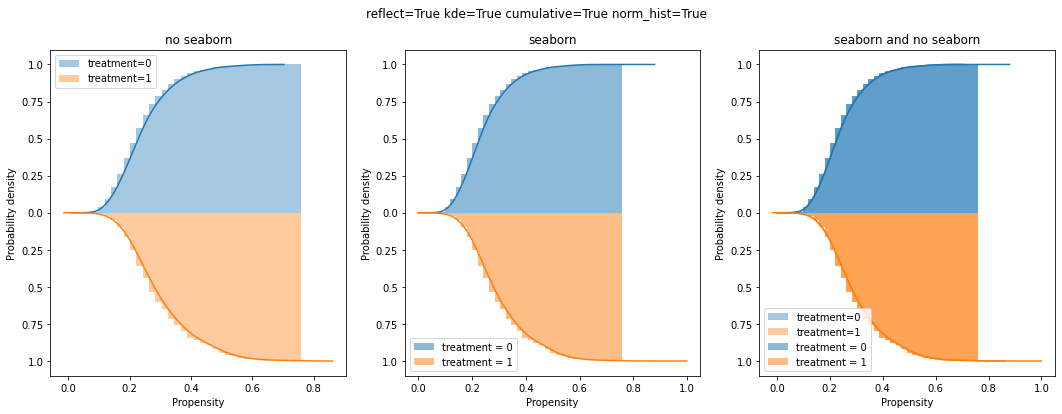

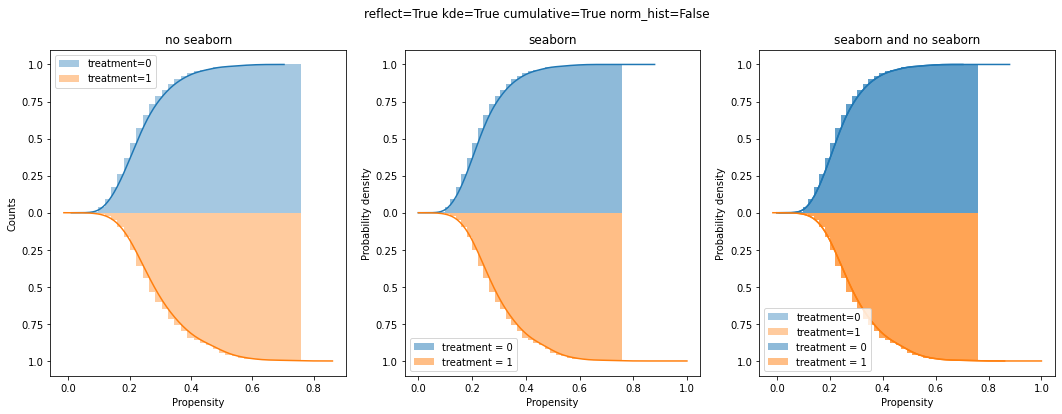

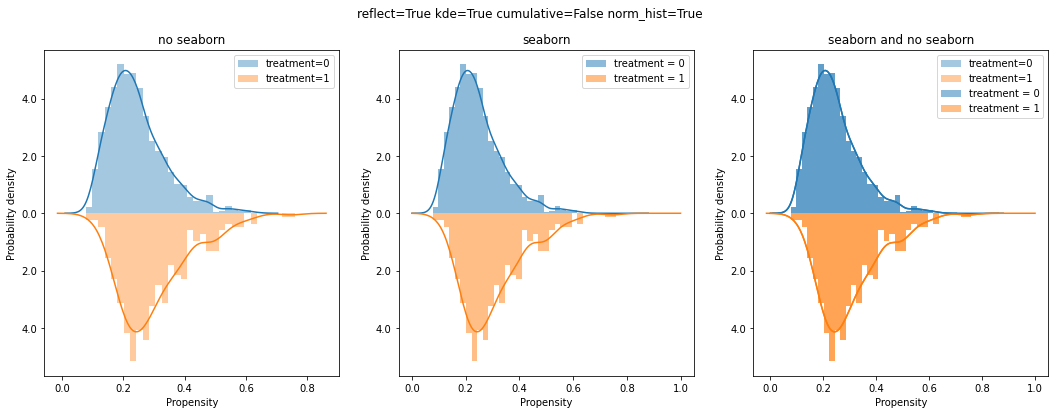

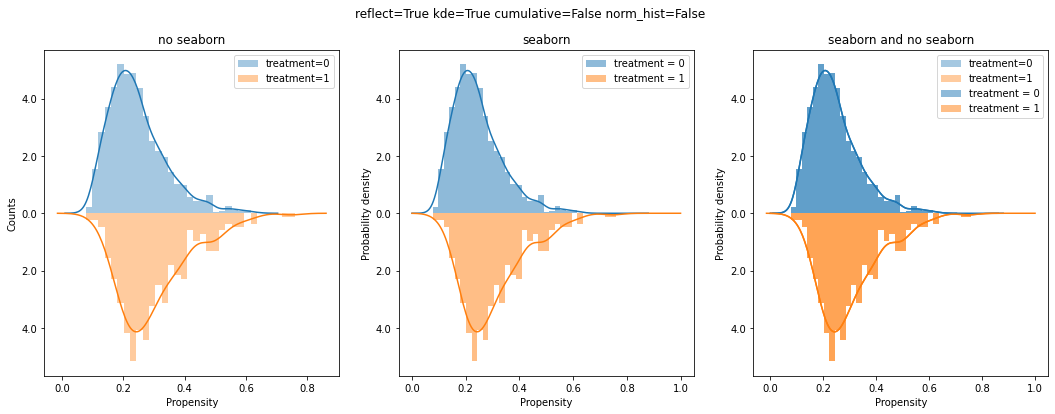

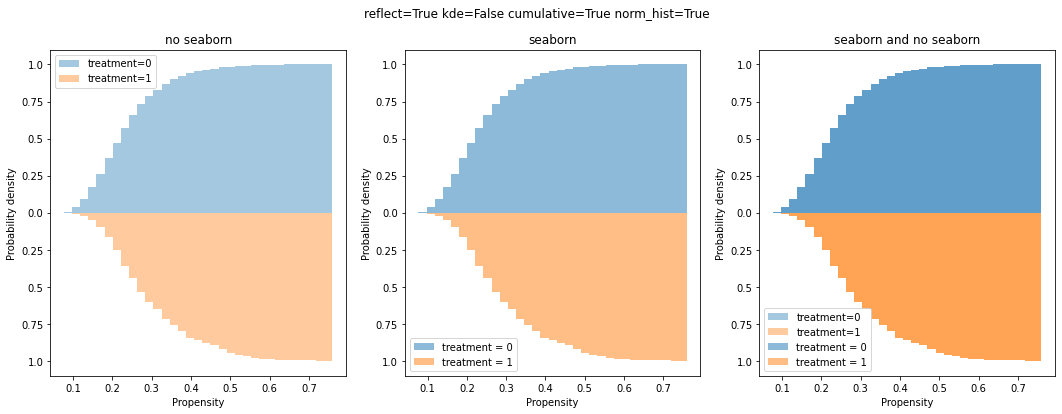

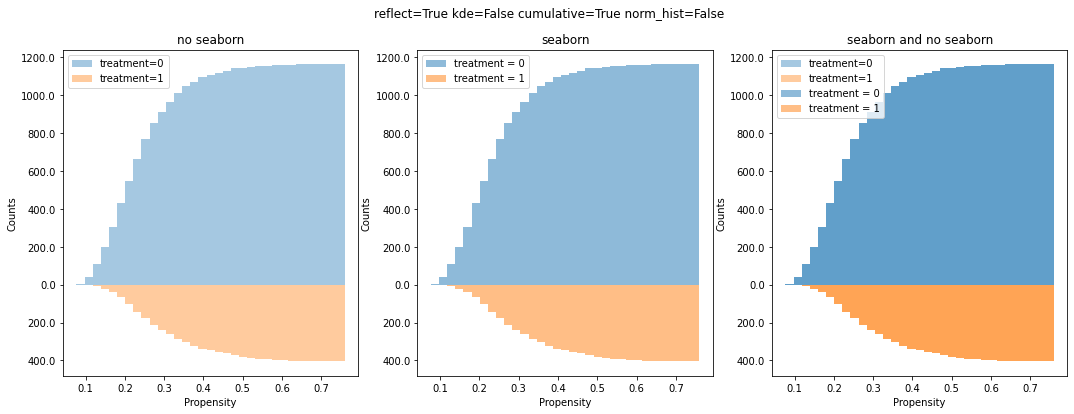

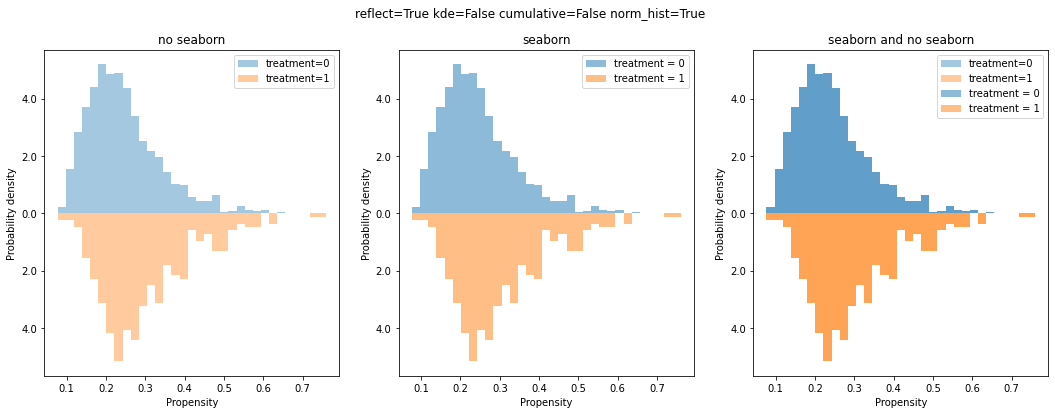

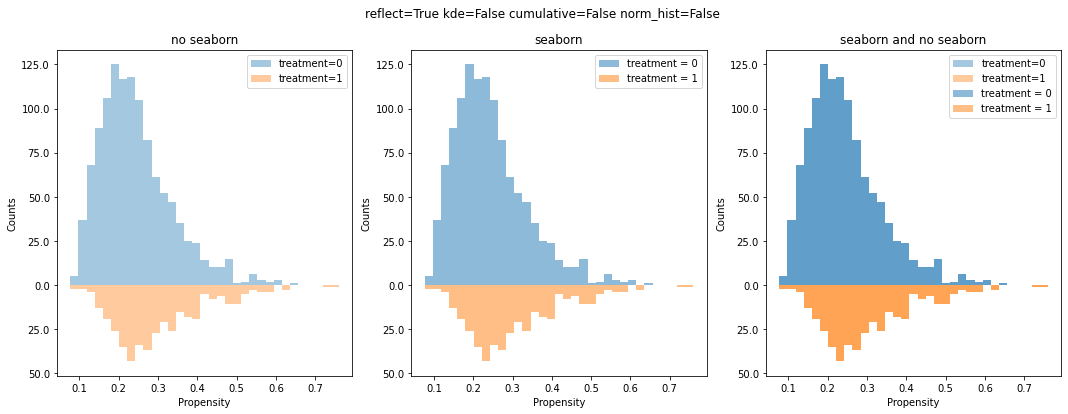

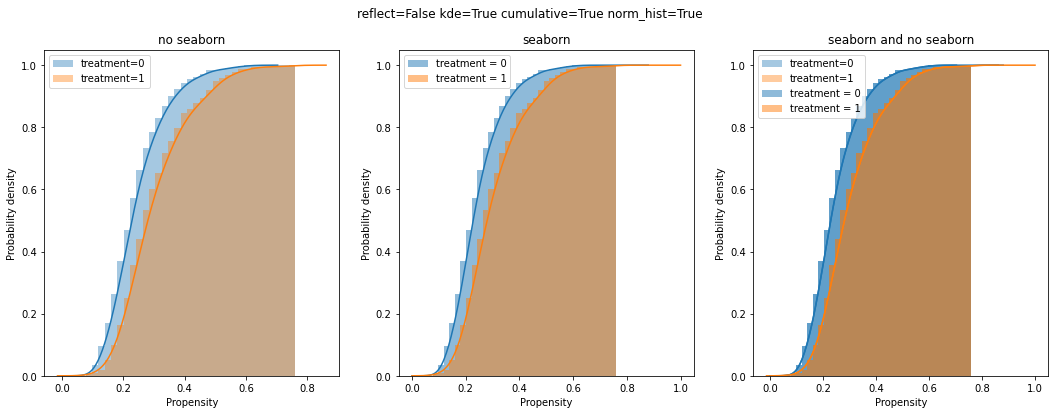

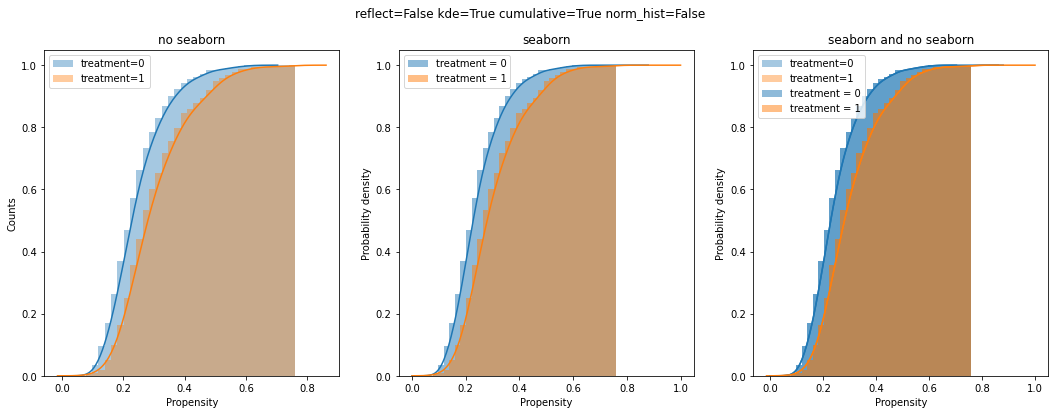

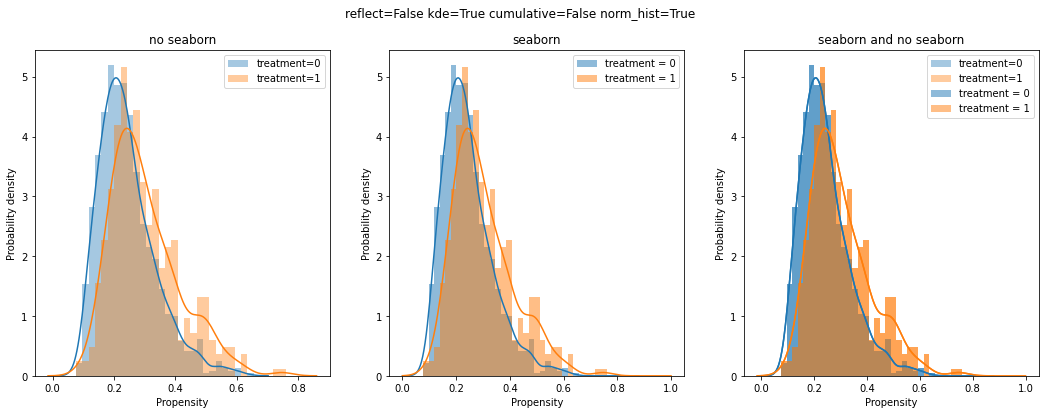

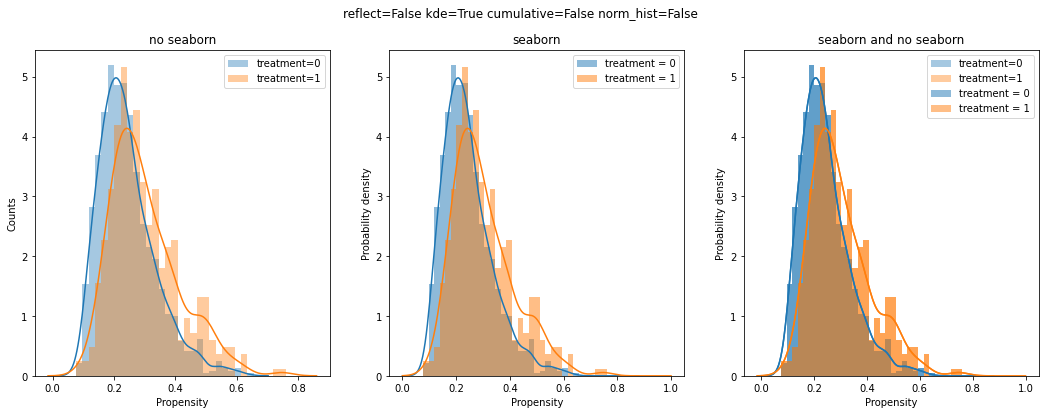

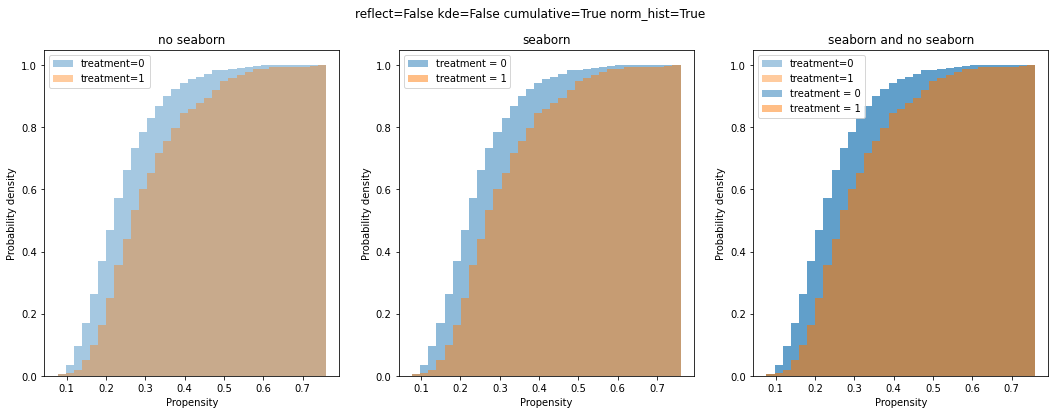

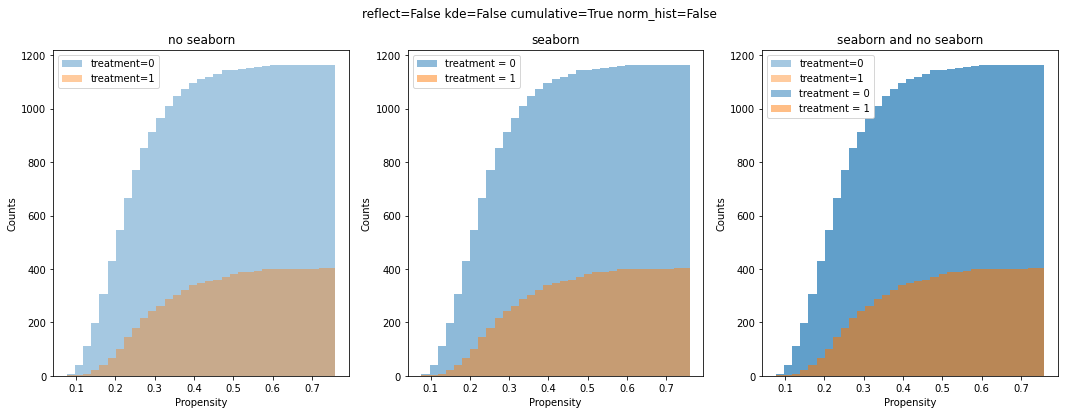

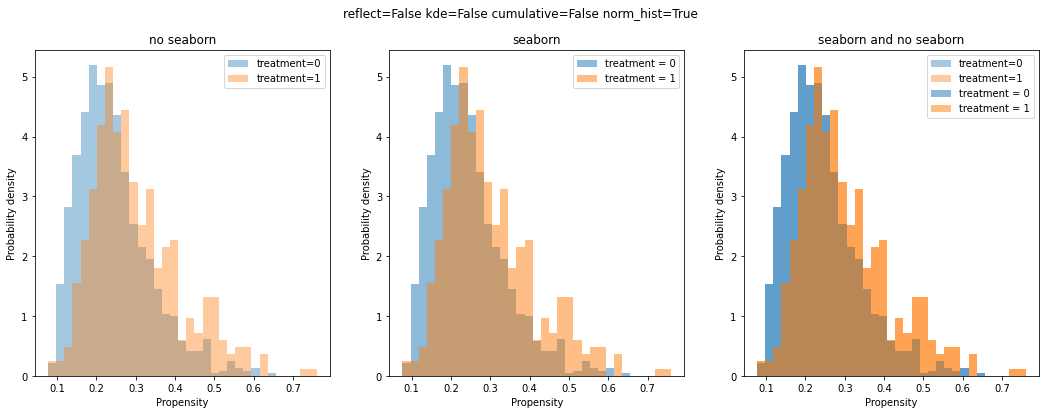

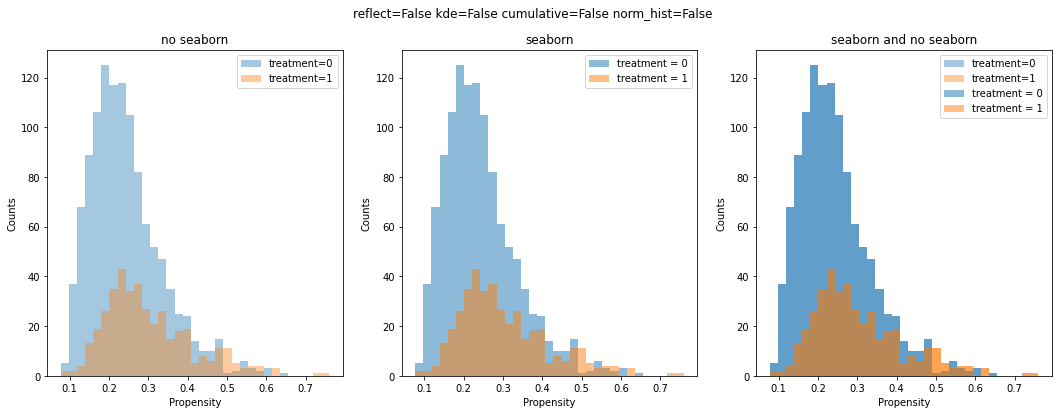

In [151]:
from itertools import product as iproduct
for reflect,kde,cumulative,norm_hist in iproduct((True,False),repeat=4):
    f,[a0,a1,a2] = plt.subplots(1,3,figsize=(18,6))


    plot_propensity_score_distribution_with_sns(propensity,data.a,ax=a0,reflect=reflect,kde=kde,cumulative=cumulative,norm_hist=norm_hist)
    
    
    plots.plot_propensity_score_distribution(propensity,data.a,ax=a1,reflect=reflect,kde=kde,cumulative=cumulative,norm_hist=norm_hist)

    
    plot_propensity_score_distribution_with_sns(propensity,data.a,ax=a2,reflect=reflect,kde=kde,cumulative=cumulative,norm_hist=norm_hist)
    plots.plot_propensity_score_distribution(propensity,data.a,ax=a2,reflect=reflect,kde=kde,cumulative=cumulative,norm_hist=norm_hist)
    
    a0.set_title("no seaborn")
    a1.set_title("seaborn")
    a2.set_title("seaborn and no seaborn")
    
    plt.suptitle(f"reflect={reflect} kde={kde} cumulative={cumulative} norm_hist={norm_hist}")
